In [1]:
import numpy as np
import random
import itertools
import scipy.misc
import matplotlib.pyplot as plt
import tensorflow as tf
import os
%matplotlib inline

In [2]:
class gameOb():
    def __init__(self,coordinates,size,intensity,channel,reward,name):
        self.x = coordinates[0]
        self.y = coordinates[1]
        self.size = size
        self.intensity = intensity
        self.channel = channel
        self.reward = reward
        self.name = name
class gameEnv():
    def __init__(self,size):
        self.sizeX = size
        self.sizeY = size
        self.actions = 4
        self.objects = []
        a = self.reset()
        plt.imshow(a,interpolation="nearest")
    def reset(self):
        self.objects = []
        hero = gameOb(self.newPosition(),1,1,2,None,'hero')
        self.objects.append(hero)
        goal = gameOb(self.newPosition(),1,1,1,1,'goal')
        self.objects.append(goal)
        hole = gameOb(self.newPosition(),1,1,0,-1,'fire')
        self.objects.append(hole)
        goal2 = gameOb(self.newPosition(),1,1,1,1,'goal')
        self.objects.append(goal2)
        hole2 = gameOb(self.newPosition(),1,1,0,-1,'fire')
        self.objects.append(hole2)
        goal3 = gameOb(self.newPosition(),1,1,1,1,'goal')
        self.objects.append(goal3)
        goal4 = gameOb(self.newPosition(),1,1,1,1,'goal')
        self.objects.append(goal4)
        state = self.renderEnv()
        self.state = state
        return state
    def moveChar(self,direction):
        hero = self.objects[0]
        heroX = hero.x
        heroY = hero.y
        if direction == 0 and hero.y >=1:
            hero.y -= 1
        if direction == 1 and hero.y <= self.sizeY-2:
            hero.y += 1
        if direction == 2 and hero.x >=1:
            hero.x -= 1
        if direction == 3 and hero.x <= self.sizeX-2:
            hero.x += 1
        self.objects[0] = hero
    def newPosition(self):
        iterables = [range(self.sizeX),range(self.sizeY)]
        points = []
        for t in itertools.product(*iterables):
            points.append(t)
        currentPositions = []
        for objectA in self.objects:
            if(objectA.x,objectA.y) not in currentPositions:
                currentPositions.append((objectA.x,objectA.y))
        for pos in currentPositions:
            points.remove(pos)
        location = np.random.choice(range(len(points)),replace=False)
        return points[location]
    def checkGoal(self):
        others = []
        for obj in self.objects:
            if obj.name == 'hero':
                hero = obj
            else:
                others.append(obj)
        for other in others:
            if hero.x == other.x and hero.y == other.y:
                self.objects.remove(other)
                if other.reward == 1:
                    self.objects.append(gameOb(self.newPosition(),1,1,1,1,'goal'))
                else:
                    self.objects.append(gameOb(self.newPosition(),1,1,0,-1,'fire'))
                return other.reward,False
        return 0.0,False
    def renderEnv(self):
        a = np.ones([self.sizeY+2,self.sizeX+2,3])
        a[1:-1,1:-1,:] = 0
        hero = None
        for item in self.objects:
            a[item.y+1:item.y+item.size+1,item.x+1:item.x+item.size+1,item.channel] = item.intensity
        b = scipy.misc.imresize(a[:,:,0],[84,84,1],interp='nearest')
        c = scipy.misc.imresize(a[:,:,1],[84,84,1],interp='nearest')
        d = scipy.misc.imresize(a[:,:,2],[84,84,2],interp='nearest')
        a = np.stack([b,c,d],axis=2)
        return a
    def step(self,action):
        self.moveChar(action)
        reward,done = self.checkGoal()
        state = self.renderEnv()
        return state,reward,done

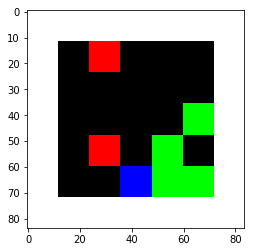

In [3]:
env = gameEnv(size=5)

In [4]:
class Qnetwork():
    def __init__(self,h_size):
        self.scalarInput = tf.placeholder(shape=[None,21168],dtype=tf.float32)
        self.imageIn = tf.reshape(self.scalarInput,shape=[-1,84,84,3])
        self.conv1 = tf.contrib.layers.convolution2d(inputs=self.imageIn,num_outputs=32,
                                                    kernel_size=[8,8],stride=[4,4],
                                                    padding='VALID',biases_initializer=None)
        self.conv2 = tf.contrib.layers.convolution2d(inputs=self.conv1,num_outputs=64,
                                                    kernel_size=[4,4],stride=[2,2],
                                                    padding='VALID',biases_initializer=None)
        self.conv3 = tf.contrib.layers.convolution2d(inputs=self.conv2,num_outputs=64,
                                                    kernel_size=[3,3],stride=[1,1],
                                                    padding='VALID',biases_initializer=None)
        self.conv4 = tf.contrib.layers.convolution2d(inputs=self.conv3,num_outputs=512,
                                                    kernel_size=[7,7],stride=[1,1],
                                                    padding='VALID',biases_initializer=None)
        self.streamAC,self.streamVC = tf.split(self.conv4,2,3)
        self.streamA = tf.contrib.layers.flatten(self.streamAC)
        self.streamV = tf.contrib.layers.flatten(self.streamVC)
        self.AW = tf.Variable(tf.random_normal([h_size//2,env.actions]))
        self.VW = tf.Variable(tf.random_normal([h_size//2,1]))
        self.Advantage = tf.matmul(self.streamA,self.AW)
        self.Value = tf.matmul(self.streamV,self.VW)
        
        self.Qout = self.Value + tf.subtract(self.Advantage,tf.reduce_mean(self.Advantage,
                                                                          reduction_indices=1,keep_dims=True))
        self.predict = tf.argmax(self.Qout,1)
        self.targetQ = tf.placeholder(shape=[None],dtype=tf.float32)
        self.actions = tf.placeholder(shape=[None],dtype=tf.int32)
        self.actions_onehot = tf.one_hot(self.actions,env.actions,dtype=tf.float32)
        self.Q = tf.reduce_sum(tf.multiply(self.Qout,self.actions_onehot),reduction_indices=1)
        self.td_error = tf.square(self.targetQ - self.Q)
        self.loss = tf.reduce_mean(self.td_error)
        self.trainer = tf.train.AdamOptimizer(learning_rate=0.0001)
        self.updateModel = self.trainer.minimize(self.loss)

In [5]:
class experience_buffer():
    def __init__(self,buffer_size = 50000):
        self.buffer = []
        self.buffer_size = buffer_size
        
    def add(self,experience):
        if len(self.buffer)+len(experience) >= self.buffer_size:
            self.buffer[0:(len(experience)+len(self.buffer))- \
                        self.buffer_size]=[]
        self.buffer.extend(experience)
        
    def sample(self,size):
        return np.reshape(np.array(random.sample(self.buffer,size)),[size,5])

In [6]:
def processState(states):
    return np.reshape(states,[21168])

def updateTargetGraph(tfVars,tau):
    total_vars = len(tfVars)
    op_holder = []
    for idx,var in enumerate(tfVars[0:total_vars//2]):
        op_holder.append(tfVars[idx+total_vars//2].assign((var.value()*tau)+((1-tau)*tfVars[idx+total_vars//2].value())))
    return op_holder

def updateTarget(op_holder,sess):
    for op in op_holder:
        sess.run(op)

In [7]:
batch_size = 32
update_freq = 4
y = .99
startE = 1
endE = 0.1
anneling_steps = 10000.
num_episodes = 10000
pre_train_steps = 10000
max_epLength = 50
load_model = False
path = "./dqn"
h_size = 512
tau = 0.001



In [8]:
mainQN = Qnetwork(h_size)
targetQN = Qnetwork(h_size)
init = tf.global_variables_initializer()

trainables = tf.trainable_variables()
targetOps = updateTargetGraph(trainables,tau)

myBuffer = experience_buffer()

e = startE
stepDrop = (startE-endE)/anneling_steps

rList = []
total_steps = 0

saver = tf.train.Saver()
if not os.path.exists(path):
    os.makedirs(path)

In [9]:
with tf.Session() as sess:
    if load_model == True:
        print('Loading Model...')
        ckpt = tf.train.get_checkpoint_state(path)
        saver.restore(sess,ckpt.model_checkpoint_path)
    sess.run(init)
    updateTarget(targetOps,sess)
    for i in range(num_episodes+1):
        episodeBuffer = experience_buffer()
        s = env.reset()
        s = processState(s)
        d = False
        rAll = 0
        j = 0
        while j < max_epLength:
            j+=1
            if np.random.rand(1) < e or total_steps < pre_train_steps:
                a = np.random.randint(0,4)
            else:
                a = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:[s]})[0]
            s1,r,d = env.step(a)
            s1 = processState(s1)
            total_steps += 1
            episodeBuffer.add(np.reshape(np.array([s,a,r,s1,d]),[1,5]))
            if total_steps > pre_train_steps:
                if e > endE:
                    e -= stepDrop
                if total_steps % (update_freq) == 0:
                    trainBatch = myBuffer.sample(batch_size)
                    A = sess.run(mainQN.predict,feed_dict={mainQN.scalarInput:np.vstack(trainBatch[:,3])})
                    Q = sess.run(targetQN.Qout,feed_dict={targetQN.scalarInput:np.vstack(trainBatch[:,3])})
                    doubleQ = Q[range(batch_size),A]
                    targetQ = trainBatch[:,2] + y*doubleQ
                    _ = sess.run(mainQN.updateModel,feed_dict={
                        mainQN.scalarInput:np.vstack(trainBatch[:,0]),
                        mainQN.targetQ:targetQ,
                        mainQN.actions:trainBatch[:,1]
                    })
                    updateTarget(targetOps,sess)
            rAll += r
            s = s1
            
            if d == True:
                break
        
        myBuffer.add(episodeBuffer.buffer)
        rList.append(rAll)
        if i>0 and i%25 == 0:
            print('episode',i,',average reward of last 25 episode',np.mean(rList[-25:]))
        if i>0 and i%1000 == 0:
            saver.save(sess,path+'/model-'+str(i)+'.cptk')
            print("Saved Model")
    saver.save(sess,path+'/model-'+str(i)+'.cptk')
            

episode 25 ,average reward of last 25 episode 2.28
episode 50 ,average reward of last 25 episode 2.0
episode 75 ,average reward of last 25 episode 0.92
episode 100 ,average reward of last 25 episode 1.8
episode 125 ,average reward of last 25 episode 2.24
episode 150 ,average reward of last 25 episode 1.64
episode 175 ,average reward of last 25 episode 1.96
episode 200 ,average reward of last 25 episode 1.64
episode 225 ,average reward of last 25 episode 1.56
episode 250 ,average reward of last 25 episode 1.44
episode 275 ,average reward of last 25 episode 2.56
episode 300 ,average reward of last 25 episode 1.52
episode 325 ,average reward of last 25 episode 2.24
episode 350 ,average reward of last 25 episode 1.92
episode 375 ,average reward of last 25 episode 1.16
episode 400 ,average reward of last 25 episode 0.32
episode 425 ,average reward of last 25 episode 0.56
episode 450 ,average reward of last 25 episode 1.52
episode 475 ,average reward of last 25 episode 0.72
episode 500 ,aver

episode 3900 ,average reward of last 25 episode 21.2
episode 3925 ,average reward of last 25 episode 20.72
episode 3950 ,average reward of last 25 episode 22.72
episode 3975 ,average reward of last 25 episode 22.56
episode 4000 ,average reward of last 25 episode 22.08
Saved Model
episode 4025 ,average reward of last 25 episode 21.56
episode 4050 ,average reward of last 25 episode 21.04
episode 4075 ,average reward of last 25 episode 19.88
episode 4100 ,average reward of last 25 episode 21.68
episode 4125 ,average reward of last 25 episode 20.64
episode 4150 ,average reward of last 25 episode 21.48
episode 4175 ,average reward of last 25 episode 22.16
episode 4200 ,average reward of last 25 episode 22.28
episode 4225 ,average reward of last 25 episode 22.76
episode 4250 ,average reward of last 25 episode 22.2
episode 4275 ,average reward of last 25 episode 22.72
episode 4300 ,average reward of last 25 episode 21.48
episode 4325 ,average reward of last 25 episode 21.56
episode 4350 ,aver

episode 7700 ,average reward of last 25 episode 22.2
episode 7725 ,average reward of last 25 episode 21.84
episode 7750 ,average reward of last 25 episode 22.2
episode 7775 ,average reward of last 25 episode 23.28
episode 7800 ,average reward of last 25 episode 24.0
episode 7825 ,average reward of last 25 episode 22.52
episode 7850 ,average reward of last 25 episode 23.36
episode 7875 ,average reward of last 25 episode 22.04
episode 7900 ,average reward of last 25 episode 22.16
episode 7925 ,average reward of last 25 episode 21.76
episode 7950 ,average reward of last 25 episode 22.76
episode 7975 ,average reward of last 25 episode 21.84
episode 8000 ,average reward of last 25 episode 23.24
Saved Model
episode 8025 ,average reward of last 25 episode 23.48
episode 8050 ,average reward of last 25 episode 23.24
episode 8075 ,average reward of last 25 episode 22.36
episode 8100 ,average reward of last 25 episode 21.76
episode 8125 ,average reward of last 25 episode 24.0
episode 8150 ,averag

AttributeError: 'Session' object has no attribute 'path'

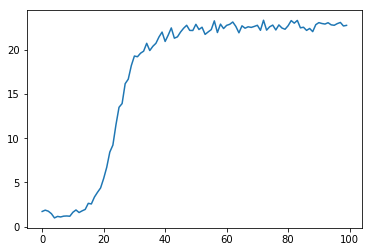

In [10]:
rMat = np.resize(np.array(rList),[len(rList)//100,100])
rMean = np.average(rMat,1)
plt.plot(rMean)